In [1]:
# imports
from moduleLoading import LoadingMethods
from modulePreProcessing import ScalingMethods, FeatureEngineeringMethods, FeatureSelectionMethods, boxplot_features
from moduleModelTraining import TrainingMethods
from moduleMetrics import MetricsMethods
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.compose import ColumnTransformer
from collections import Counter
from matplotlib import pyplot
from numpy import where
from joblib import dump
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
import numpy as np


In [2]:
# open Jupyter QtConsole
%qtconsole

In [3]:
# class instances
load = LoadingMethods()
scale = ScalingMethods()
create = FeatureEngineeringMethods()
select = FeatureSelectionMethods()
train = TrainingMethods()
evaluate = MetricsMethods()

In [4]:
# final features
ff = []

In [5]:
# connect to db and fetch data
df = load.connectAndFetch("127.0.0.1", "mci_db", "root", "toor", "SELECT * FROM v7")
df.head()

,gsId,gsStartTime,age,sex,education,laptop_usage,smartphone_usage,smoking,family_med_history,exercising,...,moca_pre_severity_binned,moca_pre_binary_binned,mmse_post_init,mmse_post_severity_binned,mmse_post_binary_binned,moca_post_init,moca_post_severity_binned,moca_post_binary_binned,mmse_post_pre_diff,moca_post_pre_diff
0,18245,1560929400,70,1,4,0,0,0,1,0,...,2,1,21,2,1,23,2,1,3,4
1,76067,1555499640,61,1,4,1,3,0,1,1,...,2,1,29,3,2,26,3,2,0,2
2,79781,1557928260,83,1,5,1,1,0,0,1,...,2,1,25,3,2,22,2,1,-4,-3
3,180144,1557315840,71,1,2,0,4,0,0,1,...,3,2,29,3,2,25,2,1,-1,-2
4,209758,1560933840,75,1,2,0,0,0,1,0,...,2,1,18,2,1,19,2,1,-3,-2


In [6]:
# define target class (14 available, 6 moca, 6 mmse, 2 diffs)
target_class = "moca_pre_binary_binned"
df = load.separateTargetClass(df, target_class)
df.head()

,gsId,gsStartTime,age,sex,education,laptop_usage,smartphone_usage,smoking,family_med_history,exercising,...,depression,hypertension,total_gr_in_gs_fixed_width_binned,total_gr_in_gs,total_success_rounds_in_session,total_win_gr_points_in_gs,total_success_round_points_in_session_win_or_lose,avg_gr_time_in_gs,avg_gr_time_win_gr_in_gs,target_class
gsId,,,,,,,,,,,,,,,,,,,,,
18245,18245,1560929400,70,1,4,0,0,0,1,0,...,0,0,0,7,1.0,33.0,122.0,14.7143,17.0,1
76067,76067,1555499640,61,1,4,1,3,0,1,1,...,0,1,3,37,4.0,67.0,305.0,41.7568,53.0,1
79781,79781,1557928260,83,1,5,1,1,0,0,1,...,0,0,1,11,4.0,17.0,53.0,38.1818,51.5,1
180144,180144,1557315840,71,1,2,0,4,0,0,1,...,0,1,3,37,1.0,39.0,364.0,34.4324,4.0,2
209758,209758,1560933840,75,1,2,0,0,0,1,0,...,0,1,2,24,1.0,26.0,140.0,29.9583,11.0,1


In [7]:
# discretize !!! also totals and avgs? check!
discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
dfPartToDiscretize = df['age']
df['age'] = discretizer.fit_transform(df[['age']])
df.head()

,gsId,gsStartTime,age,sex,education,laptop_usage,smartphone_usage,smoking,family_med_history,exercising,...,depression,hypertension,total_gr_in_gs_fixed_width_binned,total_gr_in_gs,total_success_rounds_in_session,total_win_gr_points_in_gs,total_success_round_points_in_session_win_or_lose,avg_gr_time_in_gs,avg_gr_time_win_gr_in_gs,target_class
gsId,,,,,,,,,,,,,,,,,,,,,
18245,18245,1560929400,0.0,1,4,0,0,0,1,0,...,0,0,0,7,1.0,33.0,122.0,14.7143,17.0,1
76067,76067,1555499640,0.0,1,4,1,3,0,1,1,...,0,1,3,37,4.0,67.0,305.0,41.7568,53.0,1
79781,79781,1557928260,3.0,1,5,1,1,0,0,1,...,0,0,1,11,4.0,17.0,53.0,38.1818,51.5,1
180144,180144,1557315840,1.0,1,2,0,4,0,0,1,...,0,1,3,37,1.0,39.0,364.0,34.4324,4.0,2
209758,209758,1560933840,2.0,1,2,0,0,0,1,0,...,0,1,2,24,1.0,26.0,140.0,29.9583,11.0,1


In [8]:
# encoding. no need to encode categorical features all is taken care of by the view

In [9]:
# remove low variance features # TODO print ordered
df = select.removeLowVarianceFeatures(df, (.8 * (1 - .8)))

gsId 2926025273385.5
gsStartTime 7396901279781.1
age 1.3
sex 0.1
education 1.1
laptop_usage 0.9
smartphone_usage 2.3
smoking 0.1
family_med_history 0.3
exercising 0.2
marital_status_0 0.0
marital_status_1 0.2
marital_status_2 0.0
marital_status_3 0.2
marital_status_4 0.0
marital_status_5 0.0
marital_status 1.0
depression 0.1
hypertension 0.2
total_gr_in_gs_fixed_width_binned 1.4
total_gr_in_gs 126.1
total_success_rounds_in_session 17.2
total_win_gr_points_in_gs 7534.3
total_success_round_points_in_session_win_or_lose 36471.8
avg_gr_time_in_gs 255.0
avg_gr_time_win_gr_in_gs 372.0
target_class 0.2
Threshold value  0.15999999999999998
Features ruled out  ['sex', 'smoking', 'marital_status_0', 'marital_status_2', 'marital_status_4', 'marital_status_5', 'depression']


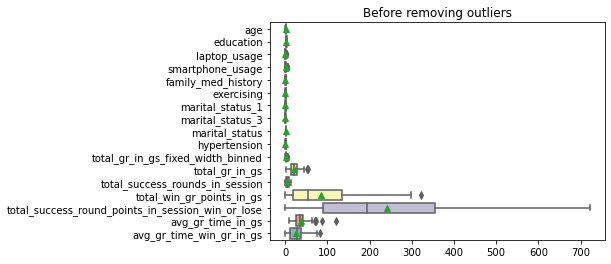

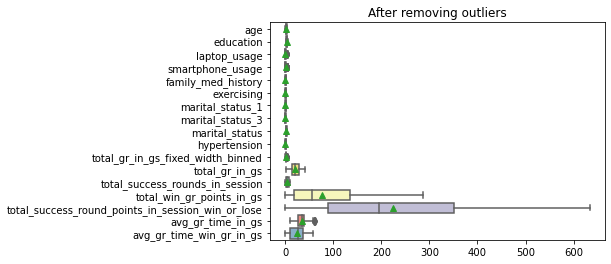

In [10]:
# handle outliers
df = scale.handle_outliers(df)

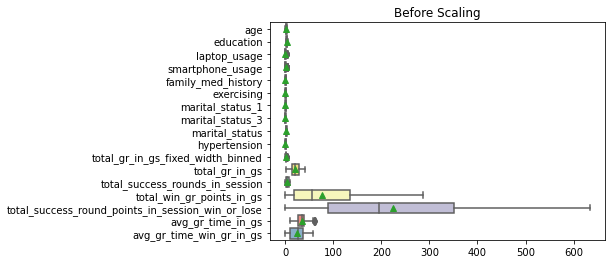

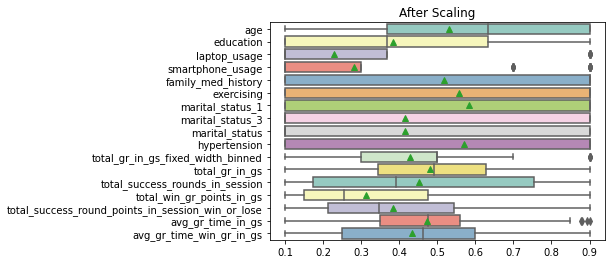

In [11]:
# scaling
columnsToIgnore = ['gsId', 'gsStartTime', 'target_class']
df = scale.useMinMax(df, columnsToIgnore)

In [12]:
# independent variables
X = df[['age', 'education','laptop_usage', 'smartphone_usage', 
         'family_med_history', 'exercising', 'marital_status_1', 
         'marital_status_3', 'hypertension']]

# target class
targetClassIndex = df.columns.get_loc('target_class')
y = df.iloc[:, targetClassIndex]

# feature selection
selector = SelectKBest(chi2, k=2)
Xresults = selector.fit_transform(X.values, y.values)
# print(Xresults.shape)
# print(type(Xresults))
#get selected as: array([3, 4], dtype=int64)
selectedFeaturesIndices = selector.get_support(indices=True)
# print('selectedFeaturesIndices ', selectedFeaturesIndices)

#get selected as: Index(['age', 'education'], dtype='object')
selectedFeaturesIndicesNames = X.columns[selectedFeaturesIndices.tolist()]
# print('selectedFeaturesIndicesNames ', selectedFeaturesIndicesNames)

#get selected as list: ['age', 'education']
selectedFeatures = X.columns[selectedFeaturesIndices.tolist()].values.tolist()
print(selectedFeatures)
ff += selectedFeatures

['smartphone_usage', 'family_med_history']


In [13]:
# independent variables
X = df[['total_gr_in_gs', 'total_success_rounds_in_session', 
        'total_win_gr_points_in_gs', 
        'total_success_round_points_in_session_win_or_lose',
        'avg_gr_time_in_gs', 'avg_gr_time_win_gr_in_gs']]

# target class
targetClassIndex = df.columns.get_loc('target_class')
y = df.iloc[:, targetClassIndex]

# feature selection
selector = SelectKBest(chi2, k=2)
Xresults = selector.fit_transform(X.values, y.values)
# print(Xresults.shape)
# print(type(Xresults))
#get selected as: array([3, 4], dtype=int64)
selectedFeaturesIndices = selector.get_support(indices=True)
# print('selectedFeaturesIndices ', selectedFeaturesIndices)

#get selected as: Index(['age', 'education'], dtype='object')
selectedFeaturesIndicesNames = X.columns[selectedFeaturesIndices.tolist()]
# print('selectedFeaturesIndicesNames ', selectedFeaturesIndicesNames)

#get selected as list: ['age', 'education']
selectedFeatures = X.columns[selectedFeaturesIndices.tolist()].values.tolist()
print(selectedFeatures)
ff += selectedFeatures

['total_success_rounds_in_session', 'total_success_round_points_in_session_win_or_lose']


Metric:  accuracy  Score: 77.857% Std.: 6.547% Raw Results: [0.75      ,0.85714286,0.85714286,0.71428571,0.71428571]
Metric:  roc_auc  Score: 86.000% Std.: 19.596% Raw Results: [1. ,1. ,0.5,1. ,0.8]
Metric:  f1  Score: 87.399% Std.: 4.101% Raw Results: [0.85714286,0.92307692,0.92307692,0.83333333,0.83333333]


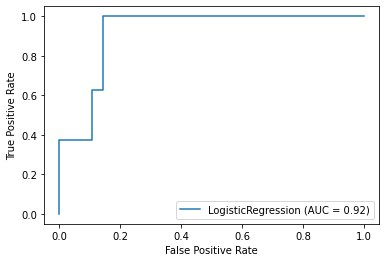

In [14]:
# Either shuffle=True, random_state=7 Or stratify=y
X_train, X_test, y_train, y_test = train_test_split(df[ff], y, test_size=0.3, stratify=y)

model_LR = LogisticRegression(random_state=7).fit(X_train, y_train)
model_DTC = DecisionTreeClassifier().fit(X_train, y_train)
model_RFC = RandomForestClassifier().fit(X_train, y_train)

# results = model_LR.score(X_test, y_test)
# print("Accuracy on test set: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))
# kfold = KFold(n_splits=10)
# kfold = StratifiedKFold(n_splits=10)
# results = cross_val_score(model_LR, df[ff], y, cv=kfold)
# print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

evaluate.generateMetrics(model_LR, X_test, y_test, ['accuracy', 'roc_auc', 'f1'])